In [46]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [71]:
from proj1_helpers import *
from UtilityFunctions import *
from datapreprocessing import *
from implementations import *
from patternsmissingvalues import *

In [80]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

# Exploring the data

In [49]:
y.shape,tX.shape,ids.shape


((250000,), (250000, 30), (250000,))

In [50]:
tX[0]

array([ 1.38470e+02,  5.16550e+01,  9.78270e+01,  2.79800e+01,
        9.10000e-01,  1.24711e+02,  2.66600e+00,  3.06400e+00,
        4.19280e+01,  1.97760e+02,  1.58200e+00,  1.39600e+00,
        2.00000e-01,  3.26380e+01,  1.01700e+00,  3.81000e-01,
        5.16260e+01,  2.27300e+00, -2.41400e+00,  1.68240e+01,
       -2.77000e-01,  2.58733e+02,  2.00000e+00,  6.74350e+01,
        2.15000e+00,  4.44000e-01,  4.60620e+01,  1.24000e+00,
       -2.47500e+00,  1.13497e+02])

In [51]:
(tX[:,0].shape,np.std(tX[:,0]))

((250000,), 406.34483401069514)

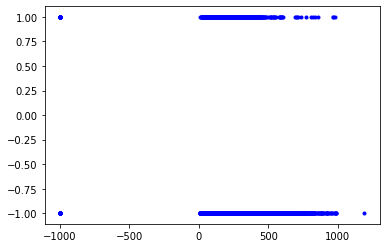

In [52]:
plt.scatter(tX[:,0],y, marker=".", color='b')

## Correlation Matrix:

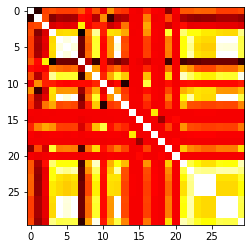

In [53]:
#corrcoef prod des vals normalisées à partir de la mat de correlation
cov = np.cov(tX.T)
#print(cov.shape, np.max(cov))
corr = np.corrcoef(tX.T)
#print(corr.shape, (corr))
plt.imshow(corr, cmap='hot')
#test

## PCA:

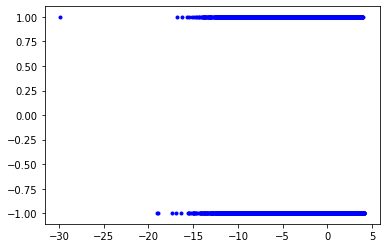

In [54]:
X_pca = pca(tX)
plt.scatter(X_pca[:,0],y, marker=".", color='b')

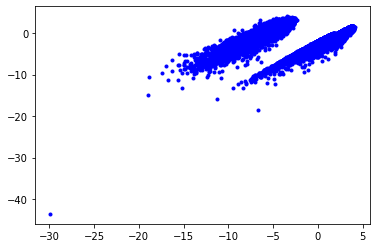

In [55]:
plt.scatter(X_pca[:,0],X_pca[:,1], marker=".", color='b')

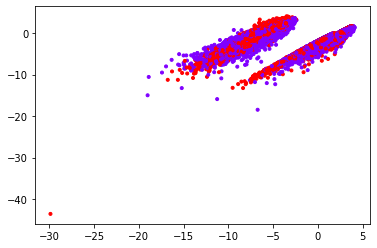

In [56]:
import matplotlib.cm as cm # To colour dots of scatter plot
colors = cm.rainbow(y)
plt.scatter(X_pca[:,0],X_pca[:,1], marker=".", color=colors)

## Missing values positions :

In [57]:
tX2 = tX.copy()
res = []
for el in tX2.T:
    res.append(el[el > -999])
print(np.array(res).shape)

mu = [np.mean(el) for el in res]
sigma = [np.std(el) for el in res]

for col, mu1, sigma1 in zip(tX2.T,mu,sigma):
    col[col == -999] = np.random.normal(mu1, sigma1, np.sum([col == -999][0]))
    
print(np.sum(tX==-999), np.sum(tX2==-999))

(30,)
1580052 0


## Distributions of the variables (w/o missing values) :

(array([1720., 1658., 1705., 1662., 1847., 1904., 1892., 1803., 1686.,
        1659., 1594., 1459., 1467., 1409., 1324., 1315., 1313., 1268.,
        1133., 1159., 1089., 1041., 1118., 1144., 1165., 1158., 1079.,
        1082., 1043., 1026., 1017., 1017., 1003.,  987.,  969.,  923.,
         920.,  924.,  970.,  899.,  832.,  912.,  812.,  801.,  817.,
         874.,  792.,  846.,  812.,  754.,  782.,  756.,  711.,  675.,
         661.,  636.,  603.,  607.,  547.,  582.,  517.,  481.,  485.,
         425.,  344.,  388.,  350.,  350.,  296.,  277.,  248.,  234.,
         222.,  175.,  176.,  171.,  124.,  138.,  132.,   90.,   91.,
          82.,   56.,   61.,   46.,   52.,   31.,   25.,   29.,   22.,
          14.,   10.,   11.,   11.,    4.,    2.,    3.,    5.,    0.,
           2.]),
 array([0.     , 0.08503, 0.17006, 0.25509, 0.34012, 0.42515, 0.51018,
        0.59521, 0.68024, 0.76527, 0.8503 , 0.93533, 1.02036, 1.10539,
        1.19042, 1.27545, 1.36048, 1.44551, 1.53054, 1.61557

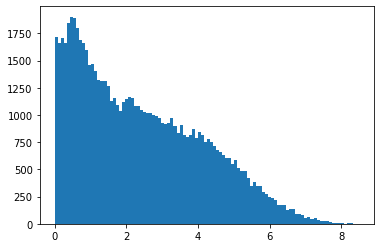

In [58]:
missing_val = np.zeros(tX.shape)
#print(missing_val.shape)
missing_val[tX==-999] = 1
total_cols = np.sum(missing_val, axis=0)/y.shape
total_rows = np.sum(missing_val, axis=1)/np.shape(tX)[1]
#print(missing_val.shape)
tX_reduced = tX[: ,total_cols < 0.5] #select only cols where less than 50% val missing and < 30% for rows
tX_reduced = tX_reduced[total_rows<0.3, :] #and < 30% for rows
y_reduced = y[total_rows<0.3]
#print(np.shape(total_rows), tX_reduced.shape)
#print(np.shape(total_rows>0.3), tX_reduced.shape)
#print(total_cols >0.5)
tXcol = [el for el in tX[:,4] if el > -999]
#plt.hist(tX[:,4])
plt.hist(tXcol, bins=100)

# Global data preprocessing :

In [82]:
x, mean_x, std_x = standardize(tX)
tX = adding_offset(x)
xtrain,ytrain,xtest,ytest=split_data(tX,y,0.9)
#pX=build_poly(tX, 5) #-- marche pas je sais pas pourquoi
#xtrainpol,ytrainpol,xtestpol,ytestpol=split_data(pX, y, 0.9) #on polynomial version,with ration= 0.9 and default seed=1


# Global implementations

## Least squares gradient descent :

In [62]:
initial_w = np.zeros(np.shape(tX)[1])
gamma = 0.0825
max_iters = 1000
final_w_gd, final_loss_gd = least_squares_GD(y, tX, initial_w, max_iters, gamma)

Gradient Descent(999/999): loss=0.38043908217146355, w0=-0.01795498667731458, w1=0.17248133194626403


## Least squares stochastic gradient descent :

In [63]:
gamma = 0.005
max_iters = 500
final_w_sgd, final_loss_sgd = least_squares_SGD(y, tX, initial_w, max_iters, gamma)

Gradient Descent(499/499): loss=0.4639727172727088, w0=-0.08148272309274819, w1=0.14951833094824463


## Least squares with normal equation  

In [64]:
w_ne,loss_ne= least_squares(y, tX)

Loss=0.339445598489575, w0=-998.8881151293799, w1=0.031342167158539415


#### on polynomial version of the data set :

In [ ]:
w_ne_pol, loss_ne_pol = least_squares(y, pX)
# tester ici quel degré est le mieux pour pX

#### and with split of test and train data :

In [ ]:
w_ne_pol_train, loss_ne_pol_train=least_squares(ytrainpol, xtrainpol)
rmse_ne_pol_train=rmse(loss_ne_pol_train)
loss_ne_pol_test= compute_loss(ytestpol, xtestpol, w_ne_pol_train)
rmse_ne_pol_test=rmse(loss_ne_pol_test)
 print(" Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(tr=rmse_ne_pol_train, te=rmse_ne_pol_test))

## Ridge regression :

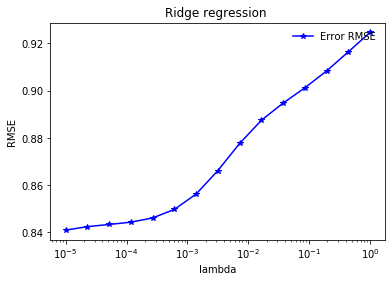

In [72]:
lambdas = np.logspace(-5, 0, 15)
rmse_rr = []
for ind, lambda_ in enumerate(lambdas):
        w_rr,loss_rr = ridge_regression(y, tX, lambda_)
        rmse_rr.append(rmse(loss_rr))

plot_implementation(rmse_rr, lambdas)

#### on polynomial version of the data set :

In [ ]:
lambdas = np.logspace(-5, 0, 15)
rmse_rr_pol = []
for ind, lambda_ in enumerate(lambdas):
        w_rr_pol,loss_rr_pol = ridge_regression(y, pX, lambda_)
        rmse_rr_pol.append(rmse(loss_rr_pol))

plot_implementation(rmse_rr_pol, lambdas)

#### and with split of test and train data :

In [ ]:
lambdas = np.logspace(-5, 0, 15)
rmse_rr_pol_train = []
rmse_rr_pol_test = []
for ind, lambda_ in enumerate(lambdas):
        w_rr_pol,loss_rr_pol_train = ridge_regression(ytrainpol,xtrainpol , lambda_)
        rmse_rr_pol_train.append(rmse(loss_rr_pol_train))
        rmse_rr_pol_test.append(rmse(compute_loss(ytestpol,xtestpol,w_rr_pol)))
plot_train_test(rmse_rr_pol_train, rmse_rr_pol_test, lambdas)

## Log likelihood

In [78]:
#### Example - base mode
gamma=0.5
ws_1,log_likelihoods_1 = logistic_regression(rescale_y(y), tX, np.random.rand(tX.shape[1])/1000000,10, gamma)
plt.scatter(rescale_predictions(compute_p(ws_1[-1],tX))[1:1000],y[1:1000], marker=".", color='b')

KeyboardInterrupt: 

In [ ]:
ws_2, log_likelihoods_2 = logistic_regression(rescale_y(y), tX, np.random.rand(tX.shape[1])/1000000,10,gamma)
plt.scatter(rescale_predictions(compute_p(ws_2[-1],tX))[1:1000],y[1:1000], marker=".", color='b')
np.linalg.norm(ws_1[-1]-ws_2[-1])

#### Optimizations

In [44]:

##### Adding w0 to the model

tX_w0 = adding_offset(tX)

print(tX_w0[0:5,0:5],tX_w0.shape)

ws_3,log_likelihoods_3 = logistic_regression(rescale_y(y), tX_w0, np.random.rand(tX_w0.shape[1])/1000000,10)

plt.scatter(rescale_predictions(compute_p(ws_3[-1],tX_w0))[1:1000],y[1:1000], marker=".", color='b')

ws_4,log_likelihoods_4 = logistic_regression(rescale_y(y), tX_w0, np.random.rand(tX_w0.shape[1])/1000000,10)

plt.scatter(rescale_predictions(compute_p(ws_4[-1],tX_w0))[1:1000],y[1:1000], marker=".", color='b')

np.linalg.norm(ws_3[-1]-ws_4[-1])

KeyboardInterrupt: 

## Split train and test datas

# Outliers gestion

##### replace -999 by average value

In [25]:
tX_corr = set_missing_explanatory_vars_to_mean(tX)

In [26]:
tX_corr[:,1:10]

array([[ 51.655,  97.827,  27.98 , ...,   3.064,  41.928, 197.76 ],
       [ 68.768, 103.235,  48.146, ...,   3.473,   2.078, 125.157],
       [162.172, 125.953,  35.635, ...,   3.148,   9.336, 197.814],
       ...,
       [ 60.526,  75.839,  39.757, ...,   2.39 ,  22.183, 120.462],
       [ 19.362,  68.812,  13.504, ...,   3.365,  13.504,  55.859],
       [ 72.756,  70.831,   7.479, ...,   2.025,   7.479,  83.24 ]])

In [27]:
tX_corr_pca = pca(tX_corr)

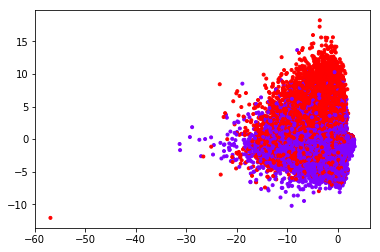

In [28]:
colors = cm.rainbow(y)
plt.scatter(tX_corr_pca[:,0],tX_corr_pca[:,1], marker=".", color=colors)

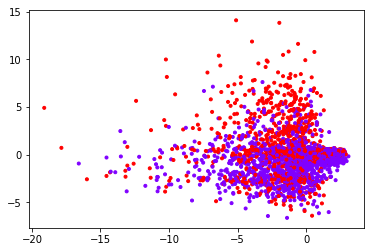

In [29]:
colors = cm.rainbow(y[1:5000])
plt.scatter(tX_corr_pca[1:5000,0],tX_corr_pca[1:5000,1], marker=".", color=colors)

##### Removing outliers

In [30]:
#find and delete outlier

ind = np.arange(len(tX_corr_pca[:,0]))
ind_outliers = ind[np.where(tX_corr_pca[:,0] < -50)] # find a suitable criterion, 
y_cleared = np.delete(y,ind_outliers)
tX_corr_cleared = np.delete(tX_corr_pca,ind[np.where(tX_corr_pca[:,0] < -50)],axis=0)

In [31]:
print(y_cleared.shape,tX_corr_cleared.shape)

(249999,) (249999, 30)


In [33]:
tX_corr_cleared_w0 = adding_offset(tX_corr_cleared)

In [34]:
ws_5,log_likelihoods_5 = logistic_regression(rescale_y(y_cleared), tX_corr_cleared_w0, np.random.rand(tX_corr_cleared_w0.shape[1])/1000000,10,gamma)

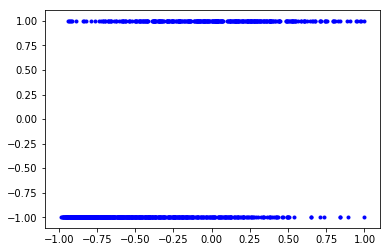

In [35]:
plt.scatter(rescale_predictions(compute_p(ws_5[-1],tX_corr_cleared_w0))[1:1000],y_cleared[1:1000], marker=".", color='b')

In [36]:
ws_6, log_likelihoods_6 = logistic_regression(rescale_y(y_cleared), tX_corr_cleared_w0, np.random.rand(tX_corr_cleared_w0.shape[1])/1000000,10,gamma)

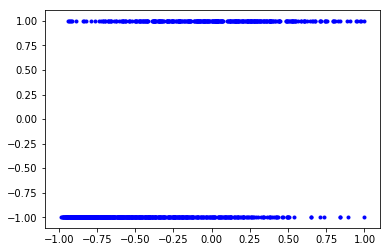

In [37]:
plt.scatter(rescale_predictions(compute_p(ws_6[-1],tX_corr_cleared_w0))[1:1000],y_cleared[1:1000], marker=".", color='b')

In [38]:
np.linalg.norm(ws_5[-1]-ws_6[-1])

5.684342030485442e-13

In [39]:
np.linalg.norm(ws_3[-1]-ws_5[-1])

554.3537652129676

In [40]:
print(ws_3[-1],ws_5[-1])

[-1.34652796e+00  5.40424102e-04 -1.85223712e-02 -2.64172287e-02
  3.44755289e-03 -1.73042395e-01  2.49856123e-03 -4.44589495e-02
  1.31879983e+00 -9.24558744e-05 -5.00281416e+00 -9.02875126e-01
  1.91416280e-01  2.63247620e-01  5.02705712e+00 -6.82474434e-04
 -2.43962306e-03  5.04970255e+00 -1.38213897e-03  2.38548561e-03
  7.20748928e-03 -5.36553193e-04 -1.60326623e-03 -4.95350355e-01
 -2.28477151e-04  9.58773005e-04  1.79975157e-04 -2.10196320e-03
 -1.59430517e-02 -2.93926396e-02  4.99868138e+00] [-8.97509936e-01 -1.79073939e-01  4.02707770e-01  1.25154479e-01
 -5.52729337e-01  7.02226098e-03 -2.71145677e-01  2.63784409e-02
  6.43942965e-03 -7.82026872e-03 -6.84468005e-03 -6.28630039e-04
  3.85375566e-01 -1.44991360e-02  5.39346423e-02  1.17965414e-03
 -3.63853067e-01  1.41556686e-01 -2.53639803e-02  9.81314592e-02
 -7.84515396e-03  7.88239736e-02 -7.82927313e-01 -3.65641293e-01
 -2.02785613e-01  7.81966575e-01 -1.46022358e+00  2.09924796e-01
 -9.94653617e-01  3.30680028e-01  5.5927

# Taking into account patterns for the handling of missing values

In [5]:
DATA_TEST_PATH = "../data/test.csv/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
DATA_TRAIN_PATH = "../data/train.csv/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [51]:
# Test that in both test and train data the same columns are full of gaps
tX_mv = sum(tX == -999) # Array with columnwise count of faulty measurements in training data
tX_mv[tX_mv > 0] = 1 
tX_test_mv = sum(tX_test == -999) # Array with columnwise count of faulty measurements in test data
tX_test_mv[tX_test_mv > 0] = 1

np.linalg.norm(tX_mv-tX_test_mv) # = 0 means both training and test data have values missing only in the excact same explanatory variables.

0.0

In [52]:
# Missing values don't appear to be random
tX_mv = sum(tX == -999)
tX_test_mv = sum(tX_test == -999)

print(tX_mv,tX_test_mv) # Arrays with columnwise counts of faulty measurements in training and test data

[ 38114      0      0      0 177457 177457 177457      0      0      0
      0      0 177457      0      0      0      0      0      0      0
      0      0      0  99913  99913  99913 177457 177457 177457      0] [ 86488      0      0      0 402796 402796 402796      0      0      0
      0      0 402796      0      0      0      0      0      0      0
      0      0      0 227458 227458 227458 402796 402796 402796      0]


In [53]:
ind = np.arange(tX.shape[1])
tX_col_mv = tX[:,ind[np.where(tX_mv > 0)]]
test = np.zeros(tX_col_mv.shape)
test[np.where(tX_col_mv == -999)] = 1
print(test[1:10,:]) # Extracted coulums that contain -999s. '1' represents missing value, '0' otherwise.

[[0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.]]


In [54]:
np.flip(np.power(10,np.arange(test.shape[1]),dtype=np.int64)) # Sleight of hand: matrix multiplication  with the following array.

array([10000000000,  1000000000,   100000000,    10000000,     1000000,
            100000,       10000,        1000,         100,          10,
                 1], dtype=int64)

In [55]:
np.dot(test,np.flip(np.power(10,np.arange(test.shape[1]),dtype=np.int64))) # The pattern of missing columns is represented by an array of numbers representing all samples in the usual order. The numbers are binary code for the matrix of the extracted columns just above.

array([0.00000000e+00, 1.11100011e+09, 1.11110001e+10, ...,
       1.11100011e+09, 1.11111111e+09, 1.11111111e+10])

In [56]:
np.unique(np.dot(test,np.power(10,np.arange(test.shape[1]),dtype=np.int64))) # All the different configurations of the missing values. There are only six of them.

array([0.00000000e+00, 1.00000000e+00, 1.11000111e+10, 1.11000111e+10,
       1.11111111e+10, 1.11111111e+10])

#### Pattern of missing values and logistic regession

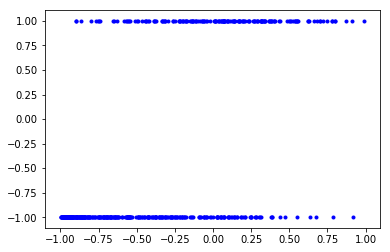

In [57]:
# Splitting the data...
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX) # => regroupement of the steps performed above
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

'''import matplotlib.cm as cm

for tX_group, y_group in zip(tX_split,y_split):
    tX_group_pca = pca(tX_group)
    colors = cm.rainbow(y_group)
    plt.scatter(tX_group_pca[:,0],tX_group_pca[:,1], marker=".", color=colors)'''

# ... and finding each subgroup's the optimal weights as well as predicting the y's of the training set using linear regression
#     => condensed version is the function 'find_optimal_weights_pattern_mv'

ws_groups = [] # list to stock weights of subgroups
y_pred = np.zeros([len(y)]) # initialize array y_pred

for tX_group, y_group, ind_row_group in zip(tX_split,y_split,ind_row_groups) :
    #print(tX_group, y_group, ind_row_group)
    
    # All-zero columns appear in the reduced data sets. They interfere with the calculation of the jacobean matrix.
    # The corresponding weights are set to zero and the other weights are determined using a further reduced dataset without those columns.
    
    ind_col_non_zero = np.arange(len(tX_group[0,:]))[sum(tX_group**2)>0]
    ws_1,log_likelihoods_1 = logistic_regression(rescale_y(y_group), tX_group[:,ind_col_non_zero], np.random.rand(tX_group[:,ind_col_non_zero].shape[1])/1000000,10,gamma)
    ws_2,log_likelihoods_2 = logistic_regression(rescale_y(y_group), tX_group[:,ind_col_non_zero], np.random.rand(tX_group[:,ind_col_non_zero].shape[1])/1000000,10,gamma)
    assert np.allclose(ws_1[-1], ws_2[-1]) # The weights are calculated twice with different initial ws => asserting that they are the same.
    w = np.zeros(len(tX_group[0,:]))
    w[ind_col_non_zero] = ws_1[-1]
    ws_groups.append(w)
    y_pred[ind_row_group] = rescale_predictions(compute_p(w,tX_group))

plt.scatter(y_pred[1:500],y[1:500], marker=".", color='b') # Plotting the predictions against the known values of the training set.

In [63]:
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)


''' Auxiliary function that calculates the predictions of each subgroup, joins them together in the right order
    and rescales the predictions so that they lie between -1 and 1'''
y_pred_test = predict_y_lr_weights_pattern_mv(ws_groups, tX_split_test,ind_row_groups_test,tX_test.shape[0])

C:\Users\Balz\Documents\GitHub\ML_course\projects\project1\scripts\proj1_helpers.py:261: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tX_split.append(tX_group_rows[:,ind_col[bool_mask_col_mv_group]])


In [ ]:
# The same with helper functions
DATA_TRAIN_PATH = "../data/train.csv/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [ ]:
# Splitting the data...
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX)
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

In [ ]:
# Adding interaction terms to the split data and calculating the optimal weights of each subgroup.
ws_groups, y_pred = find_optimal_weights_pattern_mv(tX_split_test, ind_row_groups,y_split,tX.shape[0])
plt.scatter(y_pred,y, marker=".", color='b')

In [ ]:
plt.scatter(y_pred[ind_row_groups[4]][0:800],y[ind_row_groups[4]][0:800], marker=".", color='b')

In [ ]:
DATA_TEST_PATH = "../data/test.csv/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)
y_pred_test = predict_y_lr_weights_pattern_mv(ws_groups, tX_split_test,ind_row_groups_test,tX_test.shape[0])

In [ ]:
y_pred_tX = y_pred
y_pred_test_tX = y_pred_test
ws_groups_tX = ws_groups

### Interactions between variables

In [64]:
x = np.array([[1,2,3],[4,5,6]])
print(add_interaction_terms(x),add_square_terms(x))

[[ 1  2  3  1  2  3  4  6  9]
 [ 4  5  6 16 20 24 25 30 36]] [[ 1  2  3  1  4  9]
 [ 4  5  6 16 25 36]]


In [65]:
print(add_higher_degree_terms(x, 3))

[[  1   2   3   1   4   9   1   8  27]
 [  4   5   6  16  25  36  64 125 216]]


#### Best version so far: Pattern of missing values, interactions between variables and logistic regession

#### Squares of explanatory variables

In [95]:
DATA_TRAIN_PATH = "../data/train.csv/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [96]:
# Splitting the data...
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX)
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

C:\Users\Balz\Documents\GitHub\ML_course\projects\project1\scripts\proj1_helpers.py:268: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


[     0      5      6 ... 249985 249993 249994]
[-47211.665076732934, -34353.977061519494, -32068.54078820151, -31077.769270095887, -30546.437257804857, -30372.578733203623, -30354.788845446434, -30354.602217455827, -30354.60219532964, -30354.602195329724, -30354.602195329593, -30354.60219532962, -30354.602195329506, -30354.602195329742, -30354.602195329586, -30354.602195329684] [array([ 8.04590167e-10,  8.72918392e-09,  6.59758090e-10,  6.30521242e-10,
        4.77990412e-07,  6.23425941e-11, -2.05972983e-06,  1.58055611e-07,
        7.33487041e-09,  8.08744968e-11,  3.07138027e-06,  2.62012275e-06,
        1.84236247e-06,  5.04856001e-09, -1.35805773e-03,  7.75284614e-04,
        6.30340775e-09, -1.21878219e-03,  7.21095340e-05,  1.89248309e-09,
        5.04476859e-04,  7.79825455e-11,  1.94525958e-07,  1.83962131e-10,
       -2.76455605e-04, -4.83943675e-05,  3.19338533e-09, -2.27943137e-04,
       -4.67790052e-04,  4.87563702e-10,  1.52728038e-15,  4.69798994e-13,
        4.9640389

[-48509.74853456088, -36946.2951999459, -34868.45415208219, -34057.64012679802, -33708.401729555335, -33628.59775717809, -33625.49260548466, -33623.89608697468, -33624.06736762108, -33625.320847653755, -33623.95948289243, -33623.9259632919, -33623.914105736236, -33623.95512975217, -33623.92942583727, -37068.22419270414] [array([ 1.83943715e-11,  7.16387532e-09,  2.30767539e-09,  2.84375252e-09,
        1.14236748e-06,  1.09891478e-08,  1.05182371e-10,  3.00948383e-06,
        6.83533154e-06,  3.97015173e-09, -6.70058203e-04, -1.24975285e-04,
        7.77966434e-09,  5.01100386e-04,  4.53792735e-05,  5.30873980e-09,
       -1.89251827e-03,  1.08033958e-10,  9.44171048e-06,  2.93266107e-11,
       -6.17964733e-03, -2.06571070e-04,  9.91598508e-10,  8.29742003e-15,
        7.20633423e-13,  6.09590363e-14,  6.94319773e-14,  2.32091457e-07,
        9.01840530e-12,  5.04878083e-15,  6.26519435e-07,  1.23814060e-06,
        1.31439951e-12,  9.80424318e-07,  2.22407577e-07,  2.08845314e-13,
  

C:\Users\Balz\Documents\GitHub\ML_course\projects\project1\scripts\proj1_helpers.py:98: RuntimeWarning: divide by zero encountered in log
  return sum(y*np.nan_to_num(np.log(p))+(1-y)*np.nan_to_num(np.log(1-p)))


[-51147.87026857731, -34404.71927838703, -32677.152820283507, -32354.82044976238, -32214.630346322658, -32087.316603846913, -32082.295472886406, -32082.253937003534, -32082.25393363732, -32082.25393363739, -32082.25393363724, -32082.25393363771, -32082.253933637345, -32082.25393363704, -32082.25393363675, -32082.253933637145] [array([ 6.22867148e-10,  4.71274071e-09,  2.21270525e-09,  1.97818675e-08,
        3.39675207e-07,  3.01815919e-09,  2.89169339e-10,  2.52923063e-06,
       -2.22201065e-06,  1.50460541e-08, -8.64055965e-05, -3.44619988e-05,
        4.21573492e-09, -5.98401273e-05,  5.47952890e-05,  1.49526252e-08,
       -2.71956380e-05,  6.05792564e-10,  9.16781262e-15,  3.43892540e-13,
        4.44560309e-14,  5.67062464e-13,  2.32544051e-07,  5.44022474e-13,
        3.81341002e-14,  8.43478126e-07,  3.76985308e-06,  3.42891955e-12,
        2.40535375e-06,  3.12542625e-07,  2.08635988e-12,  4.43435995e-07,
        2.06736471e-07,  3.16080115e-13,  6.22171916e-07,  1.01853840e-

[-3070.043252030282, -1309.8164033984087, -1094.40797732155, -1041.8799508695022, -1028.517084009293, -1024.4778270864567, -1018.098341598514, -1015.5065457209356, -1015.2233200038787, -1015.2208639178697, -1015.2208637239063, -1015.2208637239733, -1015.2208637239198, -1015.2208637239486, -1015.2208637239465, -1015.2208637238832] [array([ 1.62106088e-09,  1.32838414e-09,  1.62147876e-09,  5.96618670e-07,
        7.81317638e-11,  2.43326181e-05,  1.72802967e-06,  3.00063679e-09,
        6.31595966e-11,  3.40810708e-07, -4.97751001e-06,  1.89000459e-05,
        9.58372041e-09,  1.47965835e-05,  9.62501228e-04,  2.72949323e-09,
        1.42924545e-05,  1.19381035e-05,  8.70387755e-10, -5.78281144e-05,
        5.12175013e-11,  1.19663246e-06,  2.03932579e-10, -6.88443779e-05,
        5.44817877e-05,  6.05270862e-09,  6.88543584e-04,  2.55586780e-05,
        5.10070636e-10,  3.81974667e-15,  1.26306360e-14,  4.10358005e-14,
        1.00794244e-07,  8.64196619e-18,  3.62106715e-08,  2.314211

C:\Users\Balz\Documents\GitHub\ML_course\projects\project1\scripts\proj1_helpers.py:98: RuntimeWarning: overflow encountered in double_scalars
  return sum(y*np.nan_to_num(np.log(p))+(1-y)*np.nan_to_num(np.log(1-p)))


Singular matrix
-inf [-3.37245734e+05 -3.02083473e+05 -1.81984719e+05 -7.90577700e+03
 -5.95542730e+04 -4.76428190e+05 -5.73369500e+03  3.11580200e+03
 -1.18176467e+05 -9.78219000e+02 -1.10075900e+03 -1.63517201e+05
 -1.52154700e+03 -1.62445000e+02 -2.52643776e+05  4.09915000e+02
 -6.64563674e+05 -3.62800000e+03 -1.94734196e+05 -8.69199000e+02
  8.75040000e+01 -1.94734179e+05 -3.37543610e+07 -3.75928910e+07
 -1.33297888e+07 -2.09281805e+04 -1.69702084e+06 -6.67130118e+07
 -1.15338682e+04 -4.05973626e+03 -4.99088512e+06 -6.17731434e+03
 -1.22243687e+04 -8.68667180e+06 -7.04283443e+03 -1.11556766e+04
 -1.86401283e+07 -1.11795371e+04 -1.34724695e+08 -3.62800000e+03
 -1.22170444e+07 -1.12700694e+04 -1.25712286e+04 -1.22170417e+07] [[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]
[-5241.784676919728, -2185.037372689578, -1844.8589627410154, -inf, -in

[-18107.50658276053, -6253.2063728138055, -4783.207486030936, -4444.7408985212305, -4379.560203322402, -4373.906398182546, -4371.679542541823, -4386.28314382194, -4403.778466510351, -4385.479238334759, -4411.386099516753, -1.7976931348623157e+308, -4655.146234705885, -inf, -1.7976931348623157e+308, -inf] [array([ 4.09172588e-09,  2.30244028e-09,  6.00784488e-08,  2.60351533e-06,
        1.62142546e-08,  8.20435512e-10,  5.85073932e-08, -5.56610132e-06,
        5.73785956e-09, -4.18160881e-05,  6.39697094e-05,  5.33411498e-09,
       -4.94613207e-05,  7.04888787e-05,  5.00331655e-09, -3.24440734e-05,
        1.72454582e-09,  1.03021390e-13,  3.18553730e-14,  3.71400627e-11,
        1.95528502e-07,  4.37583842e-11,  9.08655614e-15,  1.06307714e-06,
        1.32051927e-06,  7.89851110e-13,  4.80484951e-07,  1.05756637e-07,
        1.11150057e-12,  9.85598770e-07,  3.41672846e-07,  9.58323287e-13,
        1.03774794e-07,  3.15454930e-15]), array([-1.31430658e-02, -4.49827608e-04,  3.094841

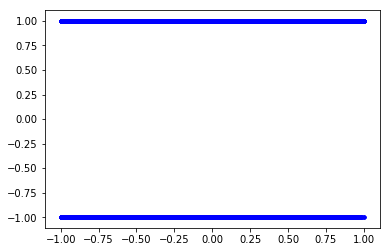

In [97]:
# Adding interaction terms to the split data and calculating the optimal weights of each subgroup.
ws_groups, y_pred = find_optimal_weights_pattern_mv(add_exponential_terms_to_split_data(tX_split_test,2), ind_row_groups,y_split,tX.shape[0])
plt.scatter(y_pred,y, marker=".", color='b')

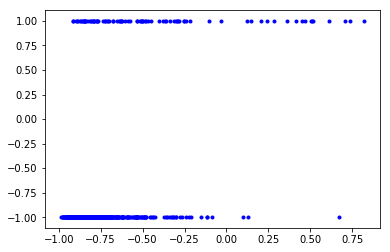

In [98]:
plt.scatter(y_pred[ind_row_groups[4]][0:800],y[ind_row_groups[4]][0:800], marker=".", color='b')

In [99]:
DATA_TEST_PATH = "../data/test.csv/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)
y_pred_test = predict_y_lr_weights_pattern_mv(ws_groups, add_exponential_terms_to_split_data(tX_split_test,2),ind_row_groups_test,tX_test.shape[0])

In [100]:
y_pred_squares = y_pred
y_pred_test_squares = y_pred_test
ws_groups_squares = ws_groups

In [102]:
len(y_pred_test_squares)

568238

#### Cubic values of explanatory variables

In [105]:
DATA_TRAIN_PATH = "../data/train.csv/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [108]:
# Splitting the data...
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX)
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

C:\Users\Balz\Documents\GitHub\ML_course\projects\project1\scripts\proj1_helpers.py:268: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tX_split.append(tX_group_rows[:,ind_col[bool_mask_col_mv_group]])


[     0      5      6 ... 249985 249993 249994]


C:\Users\Balz\Documents\GitHub\ML_course\projects\project1\scripts\proj1_helpers.py:98: RuntimeWarning: divide by zero encountered in log
  return sum(y*np.nan_to_num(np.log(p))+(1-y)*np.nan_to_num(np.log(1-p)))
C:\Users\Balz\Documents\GitHub\ML_course\projects\project1\scripts\proj1_helpers.py:98: RuntimeWarning: overflow encountered in double_scalars
  return sum(y*np.nan_to_num(np.log(p))+(1-y)*np.nan_to_num(np.log(1-p)))


Singular matrix
-inf [-8.18524450e+04 -4.01054894e+05 -1.60293278e+05  1.49472151e+05
  2.10354520e+04  5.11986371e+06 -4.81578360e+04 -4.13591900e+03
 -3.36803563e+05 -8.65817035e+05 -1.09720790e+04  7.88937800e+03
  4.59124800e+03  1.05450319e+05 -4.27495000e+02  7.53330000e+01
 -1.82894944e+05 -6.38818000e+02  2.31394000e+02  3.24630090e+04
  7.37155000e+02 -1.32072874e+06 -1.02960000e+04 -2.28332569e+05
  5.23776000e+02  4.82240000e+02 -2.00525861e+05  6.94990000e+01
 -8.35758000e+02 -7.88372325e+05 -7.74770046e+07 -3.41606587e+07
 -6.03362595e+07  7.54191473e+07  1.56391404e+05  8.86555634e+09
  2.79081190e+05 -1.39012351e+04 -2.52566545e+07 -4.30203814e+08
 -3.75241220e+04  9.73436580e+02  4.77882664e+03  1.85657971e+07
 -1.27226288e+04 -8.91886035e+03 -1.74110672e+07 -1.41697379e+04
 -9.41695909e+03  1.70676302e+07 -9.43700151e+03 -7.61319364e+08
 -3.58560000e+04 -4.20549949e+07  2.39623535e+04 -7.16668799e+03
 -2.83960647e+07  3.61136504e+04 -8.99241188e+03 -3.52224875e+08
 -4.

Singular matrix
-inf [ 1.79043429e+06  4.83279788e+05  1.14306754e+06  1.39913041e+06
  3.18465280e+04  2.88673103e+05  2.82086305e+06  1.79158420e+04
  5.66890500e+03  7.52240273e+05  6.16694700e+03  1.43256100e+03
  7.06337487e+05  1.37017070e+04 -4.42294200e+03  6.46239356e+05
  4.77429700e+03  3.63969216e+06  1.48840000e+04  1.36228531e+06
  5.06647400e+03 -7.37705000e+02  1.36228533e+06  1.88352894e+08
  2.41335679e+07  7.16612752e+07  1.93808336e+08  7.15907695e+04
  9.71590004e+06  6.39426630e+08  3.31809239e+04  1.97199443e+04
  4.71693010e+07  1.59891905e+04  4.91061800e+04  3.96326541e+07
  1.02044645e+04  4.82454526e+04  4.53005566e+07  4.78019473e+04
  1.02609769e+09  1.48840000e+04  1.82581625e+08  6.97983267e+04
  4.96220280e+04  1.82581627e+08  4.35402239e+09  1.60442833e+09
 -2.85332855e+09  3.87487026e+10  1.64226005e+05  4.23961906e+08
  1.87498929e+11  8.75560198e+04  8.17600801e+03  3.86440573e+09
  1.79886212e+04  5.00403254e+03  2.75993504e+09  4.31886551e+04
 -3.

Singular matrix
-inf [-9.18634033e+05 -9.59111860e+05 -8.46859346e+05 -1.98668176e+05
 -2.26198100e+04 -1.98668196e+05 -6.75758278e+05 -1.76095760e+04
  1.74715010e+04 -2.65522495e+05 -2.15377000e+03  2.13201400e+04
 -4.10235841e+05 -9.90938300e+03 -1.13540820e+04 -4.39647149e+05
  1.59925500e+03 -1.36204896e+06 -1.49479271e+08 -6.63703040e+07
 -1.10894656e+08 -5.82677508e+06 -5.32689644e+04 -5.82677571e+06
 -5.05709395e+07 -3.14000510e+04 -1.64975146e+04 -1.01115853e+07
 -2.39323224e+04 -3.56732864e+04 -1.72263607e+07 -2.73789500e+04
 -3.31059066e+04 -1.58378227e+07 -3.55035791e+04 -2.10543610e+08
 -4.43486633e+10 -4.51201905e+09 -2.21657894e+10 -2.04845823e+08
 -1.41203735e+05 -2.04845851e+08 -5.23885974e+09 -5.95114418e+04
  3.04476858e+04 -8.14425281e+08 -6.38857889e+03  1.24413810e+05
 -7.91051322e+08 -3.25919114e+04 -4.01932738e+04 -5.99118932e+08
  6.04074346e+03 -3.82181255e+10] [[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [

[-3070.0633081944584, -1283.1748819706422, -1049.0283008400854, -990.7735077365422, -978.3448021248581, -974.4578866978346, -973.3078885941617, -973.2335098209496, -973.2328369560564, -973.2328326387259, -973.232832637011, -973.2328326366229, -973.2328326371461, -973.2328326363703, -973.2328326375764, -973.2328326370391] [array([ 7.69624166e-10,  8.87237206e-10,  1.89526469e-10,  4.72099209e-08,
        4.87011983e-11,  9.79754381e-06,  2.10278623e-06,  7.09627507e-10,
        2.34475480e-10,  1.21429942e-06, -6.70897726e-06,  1.20106234e-05,
        7.03078098e-09,  4.67024696e-05,  5.73810085e-04,  5.55117156e-10,
        1.24659290e-04,  6.18930668e-06,  1.85566978e-09, -4.71781425e-05,
        6.33549270e-11,  1.58824737e-06,  1.57990475e-09, -8.57245863e-05,
        1.36174168e-04,  5.25968921e-09,  6.98296946e-05,  2.92110473e-05,
        3.88088575e-10,  3.17427281e-14,  6.39378108e-15,  1.14296335e-14,
        2.31838572e-08,  4.68167128e-17,  1.48582908e-08,  1.37544951e-07,
 

Singular matrix
-inf [-6.01409687e+05 -5.14698845e+05 -3.52631609e+05 -1.39396910e+04
 -9.43494940e+04 -8.46007403e+05 -1.01258900e+04  5.60958200e+03
 -2.15302791e+05 -2.85690000e+01  1.45080000e+02 -2.96754442e+05
 -4.67823000e+02 -3.00766000e+02 -4.48024323e+05  2.63489000e+02
 -1.16466372e+06 -6.44900000e+03 -3.33950209e+05 -1.66864000e+02
 -2.73950000e+01 -3.33950199e+05 -6.32639807e+07 -5.67313917e+07
 -2.59354437e+07 -3.51925034e+04 -1.83853668e+06 -1.22532848e+08
 -2.07017362e+04 -7.48872639e+03 -8.98497374e+06 -1.04643313e+04
 -2.14728897e+04 -1.67715499e+07 -1.15606273e+04 -2.12699076e+04
 -3.47958066e+07 -2.09337056e+04 -2.39177204e+08 -6.44900000e+03
 -2.19746203e+07 -2.00928146e+04 -2.12652390e+04 -2.19746183e+07
 -8.12787218e+09 -8.44614479e+09 -2.74875678e+09 -9.86842177e+04
  1.45843130e+08 -2.00896845e+10 -5.86663986e+04  8.46520374e+03
 -4.95333962e+08 -1.16225235e+02  1.36321739e+03 -1.26473949e+09
 -1.64974995e+03 -6.42486811e+02 -3.24803709e+09  1.01366633e+03
 -5.

Singular matrix
-inf [-6.78542000e+05 -5.97315807e+05 -1.03202894e+05 -1.67124320e+04
 -1.03202892e+05 -5.57220813e+05 -1.23575520e+04  1.02701370e+04
 -2.35976573e+05  1.63227000e+02  9.85494000e+02 -3.21244034e+05
 -4.51091000e+02  2.86739900e+03 -4.18708609e+05 -1.64366400e+03
 -9.51313933e+05 -5.57481061e+07 -7.12230509e+07 -2.74948152e+06
 -4.02465748e+04 -2.74948114e+06 -4.00337682e+07 -2.09340385e+04
 -1.33558265e+04 -7.70409380e+06 -1.34170996e+04 -2.74551867e+04
 -1.35333833e+07 -1.59530726e+04 -2.67975756e+04 -2.10036616e+07
 -2.92138618e+04 -1.32115858e+08 -3.74325113e+09 -1.47714872e+10
 -9.64568229e+07 -1.11531675e+05 -9.64568045e+07 -4.73180279e+09
 -3.89139847e+04  1.77543209e+04 -5.60669372e+08  3.76014184e+02
  6.04599773e+03 -7.02140773e+08  4.69592829e+02  1.70985732e+04
 -8.04910843e+08 -3.54458743e+03 -2.38254003e+10] [[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0

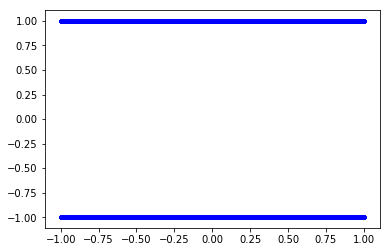

In [109]:
# Adding interaction terms to the split data and calculating the optimal weights of each subgroup.
ws_groups, y_pred = find_optimal_weights_pattern_mv(add_exponential_terms_to_split_data(tX_split,3), ind_row_groups,y_split,tX.shape[0])
plt.scatter(y_pred,y, marker=".", color='b')

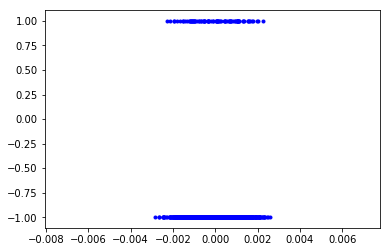

In [128]:
plt.scatter(y_pred[ind_row_groups[4]][0:800],y[ind_row_groups[4]][0:800], marker=".", color='b')

In [111]:
DATA_TEST_PATH = "../data/test.csv/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)
y_pred_test = predict_y_lr_weights_pattern_mv(ws_groups, add_exponential_terms_to_split_data(tX_split_test,3),ind_row_groups_test,tX_test.shape[0])

In [112]:
y_pred_cubic = y_pred
y_pred_test_cubic = y_pred_test
ws_groups_cubic = ws_groups

In [129]:
groups_no_conv = np.array([1,4])

In [135]:
y_pred_comb = y_pred_cubic
for group in groups_no_conv:
    y_pred_comb[ind_row_groups[group]] = y_pred_squares[ind_row_groups[group]]

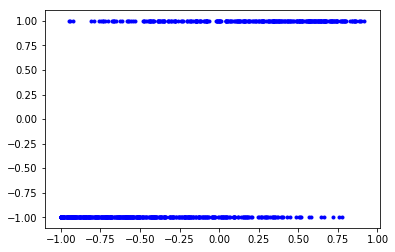

In [137]:
plt.scatter(y_pred_comb[ind_row_groups[1]][0:800],y[ind_row_groups[1]][0:800], marker=".", color='b')

In [133]:
for group in groups_no_conv:
    y_pred_test[ind_row_groups_test[group]] = y_pred_test_squares[ind_row_groups_test[group]]

#### Interactions beween all variables

In [140]:
DATA_TRAIN_PATH = "../data/train.csv/train.csv" # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [141]:
# Splitting the data...
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX)
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

C:\Users\Balz\Documents\GitHub\ML_course\projects\project1\scripts\proj1_helpers.py:268: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  tX_split.append(tX_group_rows[:,ind_col[bool_mask_col_mv_group]])


In [144]:
# Adding interaction terms to the split data and calculating the optimal weights of each subgroup.
ws_groups, y_pred = find_optimal_weights_pattern_mv(add_interaction_terms_to_split_data(tX_split), ind_row_groups,y_split,tX.shape[0])
plt.scatter(y_pred,y, marker=".", color='b')

[     0      5      6 ... 249985 249993 249994]


C:\Users\Balz\Documents\GitHub\ML_course\projects\project1\scripts\proj1_helpers.py:98: RuntimeWarning: divide by zero encountered in log
  return sum(y*np.nan_to_num(np.log(p))+(1-y)*np.nan_to_num(np.log(1-p)))
C:\Users\Balz\Documents\GitHub\ML_course\projects\project1\scripts\proj1_helpers.py:98: RuntimeWarning: overflow encountered in double_scalars
  return sum(y*np.nan_to_num(np.log(p))+(1-y)*np.nan_to_num(np.log(1-p)))


[-47212.75385066009, -31861.69993537701, -28975.211290133244, -27788.305616823145, -27333.078870506823, -inf, -inf, -inf, -inf, -inf, -inf] [array([ 4.66818560e-12,  1.13743258e-10,  1.34533271e-11,  7.15955199e-13,
        1.20081037e-09,  8.50767016e-13, -3.45502653e-08,  2.74029371e-08,
        8.31144051e-11,  3.94929766e-12,  2.41843994e-08,  1.51672388e-07,
        1.98301442e-07,  9.19488995e-12, -2.44931973e-05,  1.71157289e-05,
        2.08518994e-12, -3.63300400e-06,  9.13395949e-07,  5.67749601e-11,
        9.59487732e-06,  3.87587447e-12,  5.80262710e-08,  2.12445620e-11,
       -6.86670211e-06, -4.83079191e-06,  9.09747748e-11, -4.32532043e-06,
       -1.21788777e-05,  9.54900443e-12,  2.45379983e-16,  3.64336507e-15,
        3.80772073e-16,  1.04518112e-15,  2.60970401e-12,  5.58509349e-17,
       -2.11900894e-12,  2.75746554e-12,  7.24439883e-15,  6.45804199e-17,
        4.85122188e-12,  2.91194465e-12,  1.37494864e-11,  1.12689830e-15,
       -9.94395433e-10, -6.0023446

Singular matrix
-inf [-8.07802365e+05 -5.49301631e+05 -6.18273780e+05 -2.21661930e+05
 -1.54244885e+04 -1.03336850e+05 -7.17310543e+05 -1.43163814e+04
  6.23693439e+03 -1.41890897e+05 -8.68663898e+02 -1.31306047e+03
 -3.51956710e+05 -4.89152806e+02  1.24439788e+03 -1.82392760e+05
 -4.96786868e+02 -1.02063042e+06 -6.45723691e+03 -2.23460492e+05
 -3.72172925e+02 -1.15591517e+03 -2.23460486e+05 -1.93831195e+08
 -7.81376627e+07 -1.34170941e+08 -2.89478500e+07 -2.59714057e+06
 -1.42463674e+07 -1.08345517e+08 -1.85878864e+06  7.20594743e+05
 -2.50492234e+07 -1.70228205e+05 -1.17954220e+05 -5.43222938e+07
 -1.12201385e+05  8.37454817e+04 -2.64973245e+07 -1.77417536e+05
 -1.42964201e+08 -8.07802365e+05 -2.89738251e+07 -1.59764570e+05
  2.15787397e+04 -2.89738253e+07 -4.62466301e+07 -5.54472527e+07
 -2.50528412e+07 -1.35730455e+06 -8.92749332e+06 -7.42290654e+07
 -1.09798703e+06  3.73893743e+05 -1.67769951e+07 -1.98198438e+04
 -2.37388167e+04 -3.19129097e+07 -3.91643129e+04  2.39338958e+04
 -2.

[-51147.30516471334, -33549.63506429339, -31679.287235492884, -31196.518027514296, -31065.80959345225, -31035.890264777936, -31024.420988643466, -31023.39833638091, -31038.975164687035, -31078.653119011757, -inf] [array([ 6.35585884e-11,  2.65345402e-10,  1.31254822e-10,  1.79182872e-09,
        4.86009154e-08,  1.30448956e-09,  2.15098266e-10,  2.26995617e-07,
       -1.69415715e-07,  5.86742838e-10, -2.39166304e-06, -2.39120453e-06,
        4.75946608e-10, -4.09109584e-06,  4.35630940e-06,  3.15089494e-10,
       -8.62109460e-06,  3.63926889e-11,  1.07339583e-15,  9.23214037e-15,
        2.14514067e-15,  9.49194659e-14,  5.54060143e-12,  9.44668511e-14,
        4.60375309e-16,  1.69555322e-11, -3.82211317e-11,  6.29663038e-15,
       -7.03020220e-10, -2.38693387e-10,  1.77820446e-15, -4.65483882e-10,
        4.45490266e-10,  4.89861942e-14, -5.07819150e-10,  1.54163833e-15,
        4.01891743e-14,  2.46993137e-14,  9.08117622e-15,  3.12883803e-11,
        6.65735677e-14,  1.66338529e

[-3069.94580355196, -1140.5892813424498, -849.8641914182625, -738.9139695840327, -691.5197137584842, -672.7627880793465, -666.0151880046676, -665.0478296294475, -676.8249592420675, -664.9502687814586, -660.5946377883693] [array([ 1.48530447e-11,  2.93079052e-11,  2.70312758e-11,  3.56683312e-08,
        1.87200684e-12,  1.04915643e-07,  1.73080065e-08,  3.81094946e-11,
        8.53479608e-13,  2.34263394e-08, -1.36486985e-08,  1.73035337e-08,
        1.86812468e-10,  2.95988110e-06,  1.66083704e-05,  3.33545278e-11,
        2.93047582e-06,  4.92199663e-07,  2.66136876e-11, -2.48883102e-06,
        1.87026837e-12,  3.94326805e-08,  3.14402717e-12, -6.56312948e-06,
        1.85350890e-06,  8.84061708e-11,  1.05089930e-05,  9.18156875e-07,
        6.91293095e-13,  4.16564952e-16,  1.18685649e-15,  1.29873881e-15,
        3.48877935e-12,  1.02834906e-17,  4.67596402e-10,  3.16784310e-13,
        6.10171283e-16,  9.29338010e-17,  1.22389469e-12, -6.44460742e-12,
        9.75626772e-12,  2.7

Singular matrix


UnboundLocalError: local variable 'log_likelihood' referenced before assignment

In [ ]:
# Adding interaction terms to the split data and calculating the optimal weights of each subgroup.
ws_groups, y_pred = find_optimal_weights_pattern_mv(add_interaction_terms_to_split_data(tX_split), ind_row_groups,y_split,tX.shape[0])
plt.scatter(y_pred,y, marker=".", color='b')

[     0      5      6 ... 249985 249993 249994]


In [ ]:
plt.scatter(y_pred[ind_row_groups[4]][0:800],y[ind_row_groups[4]][0:800], marker=".", color='b')

In [ ]:
DATA_TEST_PATH = "../data/test.csv/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)
y_pred_test = predict_y_lr_weights_pattern_mv(ws_groups, add_interaction_terms_to_split_data(tX_split_test),ind_row_groups_test,tX_test.shape[0])

In [ ]:
y_pred_interact = y_pred
y_pred_test_interact = y_pred_test
ws_groups_interact = ws_groups

#### Standartization - if one uses square and cubic values they might be larger of smaller

In [16]:
def standardize(x):

    centered_data = x - np.mean(x, axis=0)
    std_data = centered_data / np.std(centered_data, axis=0)
    
    return std_data

### !!! Overfitting

## Generate predictions and save ouput in csv format for submission:

In [27]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [28]:
OUTPUT_PATH = '../data/predicted.csv' # TODO: fill in desired name of output file for submission
tX_test, mean_x, std_x = standardize(tX_test)
tX_test  = np.c_[np.ones(tX_test.shape[0]), tX_test]
y_pred = predict_labels(w1, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [ ]:
#implementer 10% du train set comme test set